In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
#import pymc3
import math
import arviz as az
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()
import seaborn as sns

from zipfile import ZipFile
import scipy as sp


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import warnings
warnings.filterwarnings('ignore')

from scipy.special import binom

In [2]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)


In [3]:
def convert_format_month(number):
    date = dt.strptime(number, '%Y-%m-%d')
    date = dt.strftime(date, '%Y-%m')
    return date

In [4]:
def convert_format(number):
    date = dt.strptime(number, '%Y-%m-%d')
    date = date - timedelta(days=date.weekday())
    return date

In [5]:
#making decimal date from string dates adapted from stackoverflow 
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction


## Remove single child nodes from BEAST trees to allow analysis via TreeAnnotator.
### Skip this step if you already have the MCC tree

In [7]:
# Collapse branches based on a custom criterion
def custom_collapse(node):
    return  len(node.children) == 1 #and node.branchType != "leaf"

#collapsed_tree = tree.collapseBranches(collapseIf=custom_collapse)

In [23]:
all_trees =  "../multitree_coalescent/deduped_smoothed_11_07.trees"


In [26]:
### this is used to get the MCC tree
### When running this, remember to delete the original tree.trees file and afterwards, check if the "#NEXUS\nBegin trees;" heading is correct. 
with open(all_trees, "r") as infile:

        tree_counter = 0
        trees_processed = 0
        migrations_dict = {}

        for line in infile:
            if 'tree STATE_' in line:
                tree_counter += 1

                if tree_counter > 800:
                    temp_tree = StringIO( line)
                    
                    tree = bt.loadNexus(temp_tree, absoluteTime = False)
                    trees_processed += 1
                    
                    collapsed_tree = tree.collapseBranches(collapseIf=custom_collapse) ## collapse branches below 0.5 posterior probability
                    collapsed_tree.sortBranches() ## sort branches, also redraws tree

                    test = collapsed_tree.toString(nexus=True)
                    
                    target_string_end = "\nEnd;"
                    test = test.replace(target_string_end, "")
                    
                    if tree_counter > 87:
                        target_string_beginning = "#NEXUS\nBegin trees;"
                        test = test.replace(target_string_beginning, "")
                        
                        tree_string = "TREE1"
                        result_string = test.replace(tree_string, "TREE"+str(tree_counter))
                        
                    else:
                        result_string = test
                    
                    f = open("tree" + ".trees", "a")
                    f.write(result_string)
                    f.close()
                    
        f = open("tree" + ".trees", "a")
        f.write("\nEnd;")
        f.close() 
                    #print(test)

                    

## Extract out local outbreak clusters from MCC tree and plot using matplotlib

In [6]:
##this can be used to find root locations and make predefined clusters into individual subtrees.
def enumerate_subtrees_clusters(tree):

    subtype_trees=[]
    division_order = ["not_root"]
    for k in tree.Objects:
        if k.x == 0.0:
            k.traits["root"] = "root"
        else:
            k.traits['root'] = "not_root"

    
    for k in sorted(tree.Objects,key=lambda x:x.height):
    
    
        kp=k.parent     # kp is the parent node of k
 
        ## if states do not match
        if (k.branchType=='node') and (len(k.leaves)>2) and (k.x >0) and (k.parent.traits['root'] == "root"):     # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits['root'] in division_order     # traverse tree for all nodes whose traitname = kc
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()

                subtype_trees.append(("LA",subtree))
    
    return(subtype_trees)

In [7]:
#tree12=bt.loadNexus('../multitree_coalescent/results/mpox_la_mcc.tree', absoluteTime = False)
tree = bt.loadNexus('../multitree_coalescent/results/smoothed_11_07_mcc.tree', tip_regex='_([0-9\-]+)$', absoluteTime = False)
tree.setAbsoluteTime(2024.7637) # set the time to be the date of the last sequence in the dataset

In [8]:
subtype_trees = enumerate_subtrees_clusters(tree)

In [9]:
#read in cluster information
sub_meta = pd.read_csv("../multitree_coalescent/data/la_clusters_with_metadata_11_07.tsv", sep = "\t")
sub_meta.head()

#format dates
sub_meta["year_month"] = sub_meta['date'].str.rsplit("-", 1).str[-0].tolist()
sub_meta["year"] = sub_meta['date'].str.rsplit("-", 0).str[-0].tolist()
#sub_meta = sub_meta[sub_meta.year_month.str.contains('XX*')==False]
sub_meta = sub_meta[sub_meta.year_month > "2022-01"]

#convert to year month/week
sub_meta['year-week'] = sub_meta['date'].map(convert_format)
sub_meta['year-month'] = sub_meta['date'].map(convert_format_month)

#get the count of number of clusters
count_clusters = sub_meta.groupby('cluster')["strain"].count().reset_index()
sub_meta = sub_meta.merge(count_clusters, on = "cluster")
sub_meta = sub_meta.rename(columns={"strain_x": "strain", "strain_y": "size_of_cluster"}); sub_meta

date_clus = sub_meta.groupby('cluster').first().reset_index()

variant_date_df = date_clus.groupby(["year_month"])["size_of_cluster"].mean().reset_index(); variant_date_df.head()
date_clus['count'] = date_clus.groupby('year_month')['year_month'].transform('count')

#subset to relevant columns
date_clus = date_clus[["year-month", "count"]]
date_clus = date_clus.drop_duplicates().reset_index()


   size_of_cluster  year  count
0                1  2022    108
1                1  2023     35
2                1  2024     11


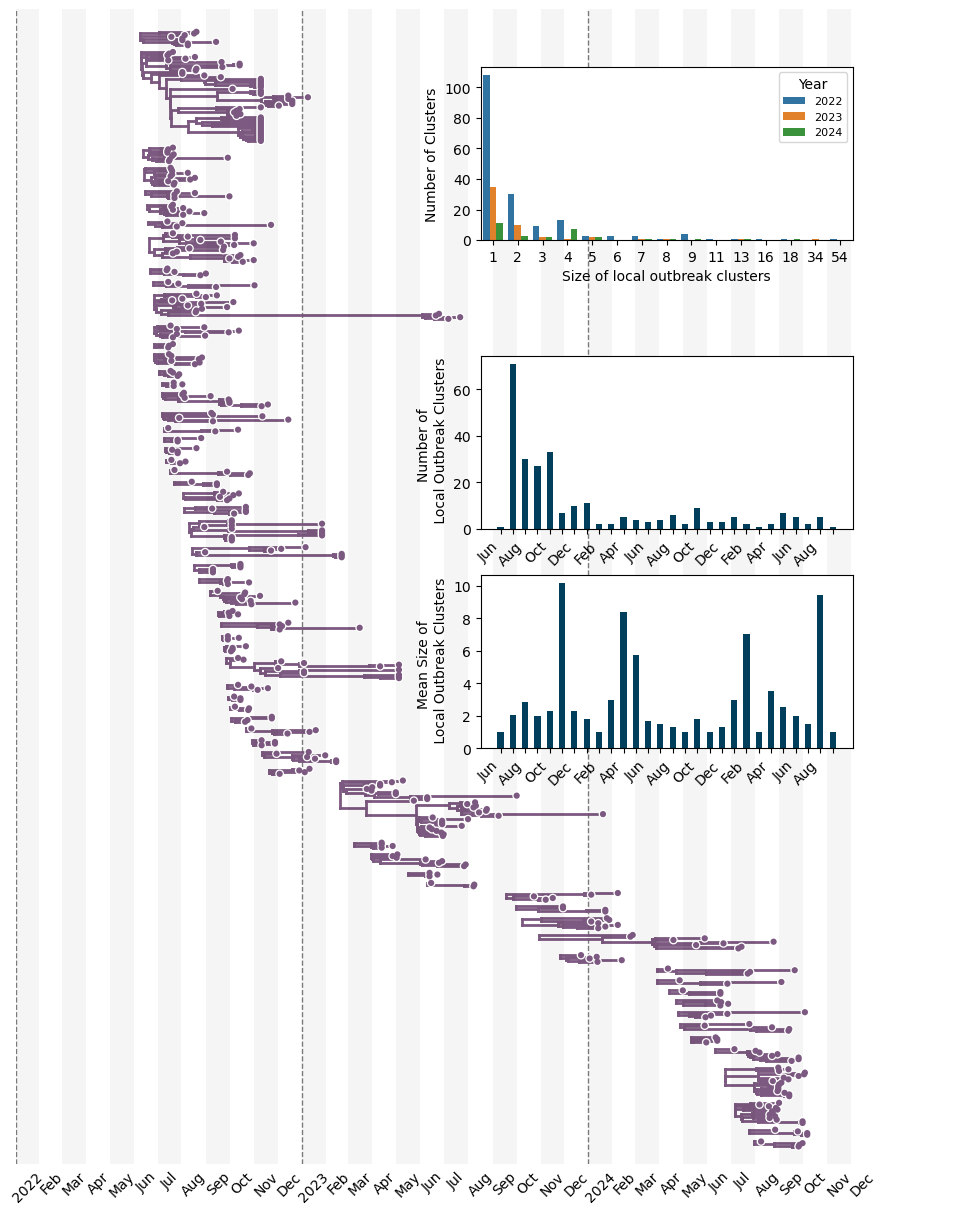

In [64]:
## plot outbreak clusters!
fig,ax = plt.subplots(figsize=(12,15),facecolor='w')
cumulativeY=0
branchWidth=2

date_clus["month_int"] = date_clus["year-month"].astype("category").cat.codes # to help with the ordering

# create inset axes
ins_ax_top = ax.inset_axes([.5, .80, .4, .15])  # [x, y, width, height] 

distribution_clus_df = sub_meta.groupby('cluster').first().reset_index()

# Aggregate data for plotting
cluster_counts = distribution_clus_df.groupby(['size_of_cluster', 'year']).size().reset_index(name='count')

print(cluster_counts[cluster_counts.size_of_cluster == 1])
print(cluster_counts["count"].sum())

# Plot using seaborn
sns.barplot(
    data=cluster_counts,
    x='size_of_cluster',
    y='count',
    hue='year',
    ax = ins_ax_top
)
## add in labels 
ins_ax_top.set_xlabel("Size of local outbreak clusters", fontsize=10)
ins_ax_top.set_ylabel("Number of Clusters", fontsize=10)
ins_ax_top.legend(title="Year", fontsize=8, title_fontsize=10, loc = "upper right")




# Create inset axes for mid chart
ins_ax_mid = ax.inset_axes([.5, .55, .4, .15])  # [x, y, width, height] w.r.t. ax

#order datafram
date_clus = date_clus.sort_values(by='month_int') 

# Plot using integer mapping for x-axis
ins_ax_mid.bar(date_clus["month_int"], date_clus["count"], color="#003f5c", alpha=1, width=0.5)


#force categorical data type
variant_date_df["month_int"] = variant_date_df["year_month"].astype("category").cat.codes

# Create inset axes
ins_ax_bot = ax.inset_axes([.5, .36, .4, .15])  # [x, y, width, height] w.r.t. ax

# Plot using integer mapping for x-axis
ins_ax_bot.bar(variant_date_df["month_int"],  variant_date_df["size_of_cluster"], color="#003f5c", alpha = 1, width = 0.5)


# Set the tick labels for mid plot
ins_ax_mid.set_xticks(date_clus["month_int"])
ins_ax_mid.set_xticklabels([convertDate(x,'%Y-%m','%b') if index % 2 == 0 else "" for index, x in enumerate(sorted(date_clus["year-month"]))], size = 10, rotation=45, ha="right")
ins_ax_mid.set_ylabel('Number of \n Local Outbreak Clusters', size=10)

# Set the tick labels directly back to the original "year-month" values for bottom plot
ins_ax_bot.set_xticks(variant_date_df["month_int"])
ins_ax_bot.set_xticklabels([convertDate(x,'%Y-%m','%b') if index % 2 == 0 else "" for index, x in enumerate(variant_date_df["year_month"])], size = 10, rotation=45, ha="right")
ins_ax_bot.set_ylabel('Mean Size of \n Local Outbreak Clusters', size=10)


for t,tr in enumerate(sorted(subtype_trees,key=lambda x:(-x[1].root.absoluteTime))): ## iterate over extracted subtrees sorted according to their root height and their size
    origin,loc_tree=tr

    for k in loc_tree.Objects:
        c='#7c5981'

        z=1

        x=k.absoluteTime
        y=k.y+cumulativeY

        xp=k.parent.absoluteTime
        if xp==0:
            xp=x

        if k.branchType=='leaf':
            ax.scatter(x,y,s=20,facecolor=c, alpha = 1, edgecolor='none',zorder=4)
            ax.scatter(x,y,s=40,facecolor='w',edgecolor='none',zorder=3)

        else:
            yl=k.children[0].y+cumulativeY
            yr=k.children[-1].y+cumulativeY
            ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=z, alpha = 1)

        if loc_tree.Objects.index(k)!=0:
            ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=z, alpha = 1)
    cumulativeY+=loc_tree.ySpan+3

    
#now make the alternating veritcal gray bars   
every=12

[ax.axvline(i,ls='--',lw=1,color='grey',zorder=0) for i in range(2022,2025)]

xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]
xDates2=['%04d-%02d-01'%(y,m) for y in range(2022,2025) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates2[x]),bt.decimalDate(xDates2[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates2),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=10,size=0, labelrotation=45) 
        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(size=0)
ax.set_yticklabels([])

ax.set_xlim(bt.decimalDate('2022-01-01'),bt.decimalDate('2025-04-01'))
ax.set_ylim(-10,cumulativeY +10)

plt.savefig('../figures/mcc_tree.png',dpi=300,bbox_inches='tight')
plt.show()